# Chinook Digital Music Shop

The [Chinook database](https://github.com/lerocha/chinook-database) contains information about fictional digital music shop - kind of like a mini-iTunes store.

The Chinook database contains information about the artists, songs, albums, invoices, as well as information on the shop's employees, customers, and the customers purchases. This information is contained in eleven tables. Below is a schema diagram for the Chinook database to understand the available columns and the structure of the data:

<img src="https://s3.amazonaws.com/dq-content/189/chinook-schema.svg" width=600 height=400/>

Source: [DataQuest](https://www.dataquest.io/)

In this project, we're going to answer business questions using SQL. Qustions like what type of genre and track are sold in USA, collate data on purchases from different countries, categorize each invoice as either an album purchase or not, and so on..

Before we proceed with our analysis, we need to connect our Jupyter Notebook to our database file:

In [1]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

The database is connected. Next, we'll import required libraries for our project:

In [2]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## Overview of the Data

Let's start by getting familiar with our data. We can query the database to get a list of all tables and views in our database. To run SQL queries in Jupyter Notebook, we have to add `%%sql` on its own line to the start of our query.

So to execute the query that returns information on the tables and views in the database, we'll use the following code:

In [3]:
%%sql
SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table","view");

 * sqlite:///chinook.db
Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


Now we'll write one or two queries to get familiar with the tables and to pratice running SQL in this interface. For reference, we can use the schema diagram from above.

In the first query, we'll get the track names and the album they belong to:

In [4]:
%%sql
SELECT
    t.name track,
    ai.title album
FROM track t
INNER JOIN album ai ON ai.album_id = t.album_id;

 * sqlite:///chinook.db
Done.


track,album
For Those About To Rock (We Salute You),For Those About To Rock We Salute You
Balls to the Wall,Balls to the Wall
Fast As a Shark,Restless and Wild
Restless and Wild,Restless and Wild
Princess of the Dawn,Restless and Wild
Put The Finger On You,For Those About To Rock We Salute You
Let's Get It Up,For Those About To Rock We Salute You
Inject The Venom,For Those About To Rock We Salute You
Snowballed,For Those About To Rock We Salute You
Evil Walks,For Those About To Rock We Salute You


Second query will give us the information about track names, the genre they represent, and their media type:

In [5]:
%%sql
SELECT
    t.name track,
    g.name genre,
    mt.name media_type
FROM track t
INNER JOIN genre g ON g.genre_id = t.genre_id
INNER JOIN media_type mt ON mt.media_type_id = t.media_type_id;

 * sqlite:///chinook.db
Done.


track,genre,media_type
For Those About To Rock (We Salute You),Rock,MPEG audio file
Balls to the Wall,Rock,Protected AAC audio file
Fast As a Shark,Rock,Protected AAC audio file
Restless and Wild,Rock,Protected AAC audio file
Princess of the Dawn,Rock,Protected AAC audio file
Put The Finger On You,Rock,MPEG audio file
Let's Get It Up,Rock,MPEG audio file
Inject The Venom,Rock,MPEG audio file
Snowballed,Rock,MPEG audio file
Evil Walks,Rock,MPEG audio file


## Select Albums to Purchase

The Chinook record store has just signed a deal with a new record label, and we've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

| Artist Name          | Genre   |
|----------------------|---------|
| Regal                | Hip-Hop |
| Red Tone             | Punk    |
| Meteor and the Girls | Pop     |
| Slim Jim Bites       | Blues   |

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

we'll need to write a query to find out which genres sell the most tracks in the USA, write up a summary of our findings, and make a recommendation for the three artists whose albums we should purchase for the store.

Things to do:

1. Write a query that returns each genre, with the number of tracks sold in the USA:
    - in absolute numbers
    - in percentage
2. Write a paragraph that interprets the data and makes a recommendaion for the three artists whose albums we should purchase for the store, based on sales of tracks from their genres.

In [7]:
%%sql

-- Extract tracks sold in USA
WITH usa_tracks_sold AS
    (
        SELECT il.*
        FROM invoice_line il
        INNER JOIN invoice i ON i.invoice_id = il.invoice_id
        INNER JOIN customer c ON c.customer_id = i.customer_id
        WHERE c.country = 'USA'
    )

-- Extract the genre types, number of tracks sold, and their percentage in USA
SELECT
    g.name AS genre,
    COUNT(uts.invoice_line_id) AS tracks_sold,
    ROUND(CAST(COUNT(uts.invoice_line_id) AS FLOAT) *100 / (
        SELECT COUNT(*) FROM usa_tracks_sold
    ), 0) AS percentage_sold
FROM usa_tracks_sold uts
INNER JOIN track t ON t.track_id = uts.track_id
INNER JOIN genre g ON g.genre_id = t.genre_id
GROUP BY genre
ORDER BY tracks_sold DESC
LIMIT 10;

 * sqlite:///chinook.db
Done.


genre,tracks_sold,percentage_sold
Rock,561,53.0
Alternative & Punk,130,12.0
Metal,124,12.0
R&B/Soul,53,5.0
Blues,36,3.0
Alternative,35,3.0
Pop,22,2.0
Latin,22,2.0
Hip Hop/Rap,20,2.0
Jazz,14,1.0


In [8]:
query = """
WITH usa_tracks_sold AS
    (
        SELECT il.*
        FROM invoice_line il
        INNER JOIN invoice i ON i.invoice_id = il.invoice_id
        INNER JOIN customer c ON c.customer_id = i.customer_id
        WHERE c.country = 'USA'
    )

SELECT
    g.name AS genre,
    COUNT(uts.invoice_line_id) AS tracks_sold,
    ROUND(CAST(COUNT(uts.invoice_line_id) AS FLOAT) *100 / (
        SELECT COUNT(*) FROM usa_tracks_sold
    ), 0) AS percentage_sold
FROM usa_tracks_sold uts
INNER JOIN track t ON t.track_id = uts.track_id
INNER JOIN genre g ON g.genre_id = t.genre_id
GROUP BY genre
ORDER BY tracks_sold DESC
LIMIT 10;
"""

# SQL output to pandas dataframe
conn = sqlite3.connect('chinook.db')
df = pd.read_sql_query(query, conn)
df = df.set_index('genre') # remove default index
df

,tracks_sold,percentage_sold
genre,,
Rock,561,53.0
Alternative & Punk,130,12.0
Metal,124,12.0
R&B/Soul,53,5.0
Blues,36,3.0
Alternative,35,3.0
Pop,22,2.0
Latin,22,2.0
Hip Hop/Rap,20,2.0


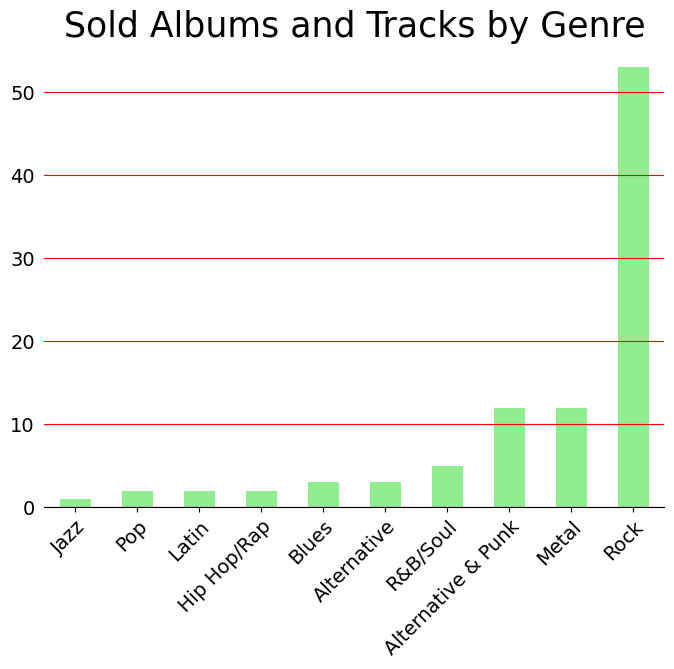

In [25]:
# Plot sold tracks in USA by genre in %
fig, ax = plt.subplots(figsize=(8, 6))

df['percentage_sold'].sort_values().plot.bar(color='lightgreen', rot=0)
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
ax.set_title('Sold Albums and Tracks by Genre', fontsize=25)
ax.tick_params(axis='both', labelsize=14, left=False)
ax.set_xlabel(None)

ax.grid(color='red', axis='y')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()

Based on the sales of tracks across different genres in the USA, we should purchase the new albums by the following three artists:

- Red Tone (Punk)
- Slim Jim Bites (Blues)
- Meteor and the Girls (Pop)

It's worth keeping in mind that combined, these three genres only make up only 17% of total sales, so we should be on the lookout for artists and albums from the `Rock` genre, which accounts for 53% of sales.

## Analyze Employee Sales Performance

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. We have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

We might like to consider whether any extra columns from the employee table explain any variance we see, or whether the variance might instead be indicative of employee performance.

Things to do:

1. Write a query that finds the total dollar amount of sales assigned to each sales support agent within the company. Add any extra attributes for that employee that we find are relevant to the analysis.
2. Write a short statement describing our results, and providing a possible interpretation.